# Predição da Concentração de NO2 no Ar de São José dos Campos (SP)

Utilizaremos modelos de regressão no contexto de Machine Learning para prever a concentração de NO2 em São José dos Campos (SP) com base no horário e na concentração de NO medida na mesma hora. Imaginemos, por exemplo, que a medição de NO ocorra logo que comece a hora. Então, a predição de NO2 poderia ser feita pelo modelo logo após a captação do valor de NO por aparelhos medidores. 

Uma situação mais prática seria, por exemplo, se considerássemos a concentração de NO aproximadamente constante entre horas subsequentes e a utilizássemos para prever a concentração de NO2 na hora seguinte.

O objetivo final é determinar alguma relação entre os poluentes NO e NO2 que possa ser descrita por um modelo de aprendizado de máquina de forma eficiente.

## Importando Bibliotecas

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

---

## Importando os Dados

In [35]:
data = pd.read_csv('data/SP_poluicao_dados.csv')

In [36]:
data = data.drop(columns = ['Unnamed: 0'])

In [37]:
data.head()

,ID,Data,Hora,Estacao,Codigo,Poluente,Valor,Unidade,Tipo
0,0,2015-01-01,01:00,Americana - Vila Santa Maria,SP01,MP10,65.0,ug/m3,automatica
1,1,2015-01-01,02:00,Americana - Vila Santa Maria,SP01,MP10,98.0,ug/m3,automatica
2,2,2015-01-01,03:00,Americana - Vila Santa Maria,SP01,MP10,79.0,ug/m3,automatica
3,3,2015-01-01,04:00,Americana - Vila Santa Maria,SP01,MP10,53.0,ug/m3,automatica
4,4,2015-01-01,05:00,Americana - Vila Santa Maria,SP01,MP10,35.0,ug/m3,automatica


---

## Filtrando os dados que vamos usar

In [38]:
data = data[data['Estacao'] == 'São José dos Campos']
data = data[(data['Poluente'] == 'NO2') | (data['Poluente'] == 'NO')]
data = data.reset_index(drop = True)
data['ID'] = data.index

### Separando os dados por poluente

In [39]:
data_NO2 = data[data['Poluente'] == 'NO2'].copy()
data_NO = data[data['Poluente'] == 'NO'].copy()

### Criando nova key para realizar inner join

In [40]:
data_NO2['Data_Hora'] = data_NO2['Data'] + ' ' + data_NO2['Hora']
data_NO['Data_Hora'] = data_NO['Data'] + ' ' + data_NO['Hora']

In [41]:
joint_data = pd.merge(data_NO, data_NO2, on = ['Data_Hora', 'Data_Hora'], how = 'inner')

### Agora nosso dataframe 'data' será aquele que utilizaremos

In [42]:
joint_data.head(2)

,ID_x,Data_x,Hora_x,Estacao_x,Codigo_x,Poluente_x,Valor_x,Unidade_x,Tipo_x,Data_Hora,ID_y,Data_y,Hora_y,Estacao_y,Codigo_y,Poluente_y,Valor_y,Unidade_y,Tipo_y
0,13867,2017-01-01,02:00,São José dos Campos,SP70,NO,2.0,ug/m3,automatica,2017-01-01 02:00,22008,2017-01-01,02:00,São José dos Campos,SP70,NO2,18.0,ug/m3,automatica
1,13868,2017-01-01,03:00,São José dos Campos,SP70,NO,2.0,ug/m3,automatica,2017-01-01 03:00,22009,2017-01-01,03:00,São José dos Campos,SP70,NO2,15.0,ug/m3,automatica


In [43]:
data = joint_data[['Data_x', 'Hora_x', 'Valor_x', 'Valor_y', 'Unidade_x']]
data = data.rename(columns = {'Data_x': 'Data',
                              'Hora_x': 'Hora',
                              'Valor_x': 'Concentração_NO',
                              'Valor_y': 'Concentração_NO2',
                              'Unidade_x': 'Unidade'})

### Transformando a coluna 'Hora' em dados numéricos

In [44]:
def hour_to_num(hour):
    hour_split = hour.split(':')
    return float(hour_split[0]) + float(hour_split[1])/60

data['Hora'] = data['Hora'].apply(hour_to_num)

In [45]:
data.head()

,Data,Hora,Concentração_NO,Concentração_NO2,Unidade
0,2017-01-01,2.0,2.0,18.0,ug/m3
1,2017-01-01,3.0,2.0,15.0,ug/m3
2,2017-01-01,4.0,1.0,7.0,ug/m3
3,2017-01-01,5.0,1.0,6.0,ug/m3
4,2017-01-01,6.0,0.0,6.0,ug/m3


Agora temos os dados prontos para iniciarmos algumas análises e depois montar um modelo de Machine Learning que prevê a concentração de NO2 com base na concentração de NO em São José dos Campos e no horário da medição.

---

## Análises

### Correlações

In [46]:
data.corr(numeric_only = True)

,Hora,Concentração_NO,Concentração_NO2
Hora,1.00000,-0.025800,0.233920
Concentração_NO,-0.02580,1.000000,0.499585
Concentração_NO2,0.23392,0.499585,1.000000


Verificamos correlações positivas entre o target (Concentração_NO2) e as features (Hora e Concentração_NO).

### Scatterplot da concentração de NO2 pela concentração de NO

Text(0.5, 0, 'Concentração de NO (mug/m^3)')

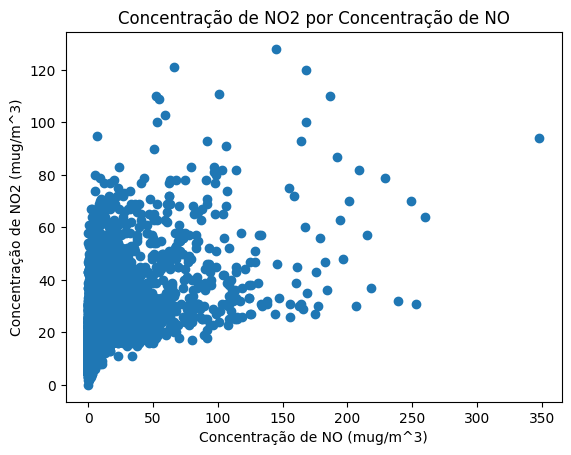

In [47]:
_ = plt.scatter(x = data['Concentração_NO'], y = data['Concentração_NO2'])
plt.title('Concentração de NO2 por Concentração de NO')
plt.ylabel('Concentração de NO2 (mug/m^3)')
plt.xlabel('Concentração de NO (mug/m^3)')

### Scatterplot da concentração de NO2 pela hora

Text(0.5, 0, 'Hora')

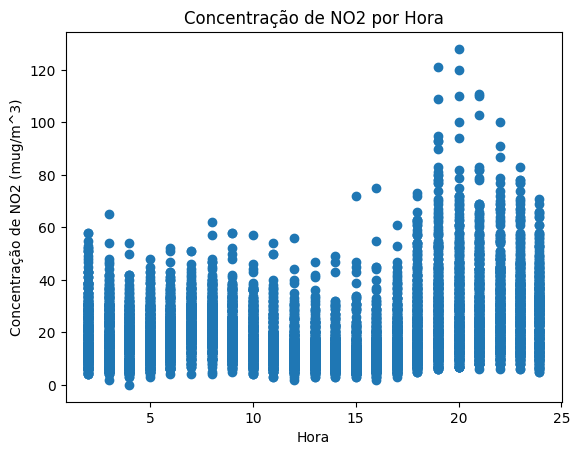

In [48]:
_ = plt.scatter(data['Hora'], data['Concentração_NO2'])
plt.title('Concentração de NO2 por Hora')
plt.ylabel('Concentração de NO2 (mug/m^3)')
plt.xlabel('Hora')

### Histograma e Boxplot da Concentração de NO

Text(0, 0.5, 'Concentração de NO (mug/m^3)')

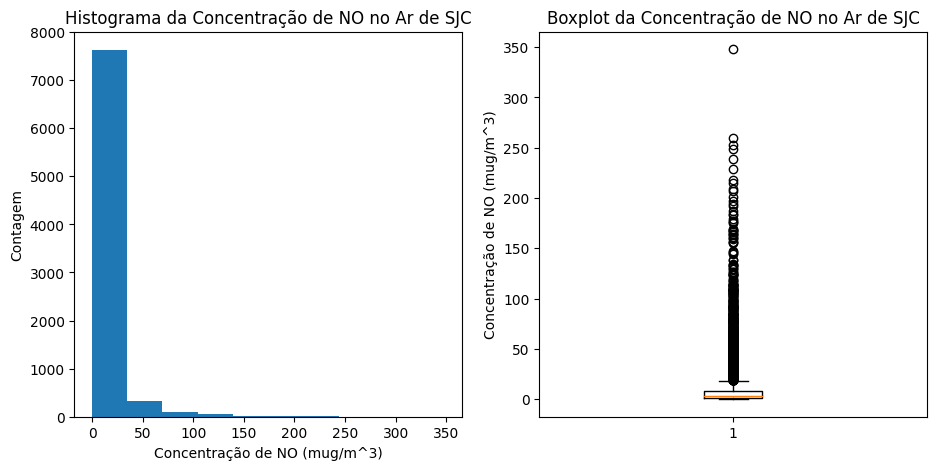

In [49]:
fig, axs = plt.subplots(1, 2, figsize = (11, 5))
axs[0].hist(data['Concentração_NO'])
axs[0].set_title('Histograma da Concentração de NO no Ar de SJC')
axs[0].set_xlabel('Concentração de NO (mug/m^3)')
axs[0].set_ylabel('Contagem')

axs[1].boxplot(data['Concentração_NO'])
axs[1].set_title('Boxplot da Concentração de NO no Ar de SJC')
axs[1].set_ylabel('Concentração de NO (mug/m^3)')

Do boxplot, verificamos que os outliers são valores aproximadamente maiores que 20 mug/m^3. Vamos determinar o valor exato:

In [50]:
data_NO2 = data['Concentração_NO']
first_quartile = data_NO2.quantile(0.25)
third_quartile = data_NO2.quantile(0.75)
interquartile_ampl = third_quartile - first_quartile
outlier_threshold = third_quartile + 1.5*interquartile_ampl

data_outliers = data_NO2[data_NO2 > outlier_threshold]
outlier_count = data_outliers.count()
outlier_percentage = 100* len(data_outliers)/len(data_NO2)

print(f'Os valores maiores que {outlier_threshold} são classificados como outliers')
print(f'Há {outlier_count} outliers, representando {round(outlier_percentage,1)}% do conjunto de dados')

Os valores maiores que 18.5 são classificados como outliers
Há 952 outliers, representando 11.7% do conjunto de dados


Diante disso, verificamos que que o número de outliers em relação ao conjunto todo de dados é considerável. Temos três linhas de ação que podemos adotar quanto a esses outliers no **conjunto de treino**:

- Eliminá-los (**Trimming**)

- Substituí-los por um valor máximo (**Clipping**)

- Manter como estão

A primeira abordagem eliminaria toda a influência dos outliers no treinamento do modelo, enquanto a segunda iria reduzí-la. Por fim, a terceira manteria a relação dos dados no treinamento do modelo.

---

## Seleção de Modelos

Verificamos que as relações entre as variáveis estão longe de serem lineares. Assim, iremos utilizar modelos de maior complexidade para que consigam se adaptar à relação entre target e features. Testaremos os seguintes:

- Random Forest
- XGBoost (Extreme Gradient Boost)

---

# 1) Random Forest

## Preparação dos dados

### Separando em features e label

- X: features
- y: label

In [51]:
features = ['Hora', 'Concentração_NO']
X = data[features]
y = data['Concentração_NO2']

In [52]:
X.head()

,Hora,Concentração_NO
0,2.0,2.0
1,3.0,2.0
2,4.0,1.0
3,5.0,1.0
4,6.0,0.0


In [53]:
y.head()

0    18.0
1    15.0
2     7.0
3     6.0
4     6.0
Name: Concentração_NO2, dtype: float64

### Pipeline de Pré-processamento, Split em treino, teste e validação, e Cross-validation via KFold

Realizaremos as seguintes etapas de pré-processamento nas colunas (todas numéricas):
- Scaling no intervalo [0,1]
- Imputation da moda (most_frequent)

A Imputation não seria necessário nesse caso porque já verificamos na EDA que não há valores faltantes no conjunto de dados. No entanto, vamos fazê-lo de forma a considerar essa situação.

### Importando bibliotecas

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

Há duas formas de fazermos a pipeline:

- Utilizando a classe Pipeline do Sklearn e realizando o fit nos dados de treino. Nesse caso, porém, não é possível realizar o pré-processamento das labels.

- Criando uma função para realizar a pipeline em cada uma das features e na label de forma separada.

Para manter a simplicidade do código, vamos criar uma classe auxiliar para fazer a 1a opção e gerar um novo modelo variando n_estimators e max_depth:

In [81]:
class Researcher():
    
    def __init__(self, X = None, y = None, test_size = 0.2, val_size = 0.2 , random_state = 0):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, 
                                                                                test_size = test_size, random_state = random_state)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, 
                                                                              test_size = val_size, random_state = random_state)
        self.random_state = random_state
        
    def _get_train_test_val_predictions(self, model):
        model.fit(self.X_train, self.y_train)
        preds_train = model.predict(self.X_train)
        preds_test = model.predict(self.X_test)
        preds_val = model.predict(self.X_val)
    
        predictions = {'train': preds_train, 'test': preds_test, 'val': preds_val}
    
        return predictions
       
    def _get_train_test_val_errors(self, model):
        predictions = self._get_train_test_val_predictions(model)
        train_error = mean_squared_error(self.y_train, predictions['train'])
        test_error = mean_squared_error(self.y_test, predictions['test'])
        val_error = mean_squared_error(self.y_val, predictions['val'])
        
        errors = {'train error': train_error, 'val error': val_error, 'test error': test_error}
        
        return errors
    
    def _get_kfold_mean_score(self, model, k):
        indexes = np.array(self.X.index)
        rand = np.random.RandomState(self.random_state)
        rand.shuffle(indexes)
        X_shuffled = self.X.loc[indexes]
        y_shuffled = self.y.loc[indexes]
        kfold_scores = -1 * cross_val_score(model, X_shuffled, y_shuffled, cv = k, scoring = 'neg_mean_squared_error')
        return kfold_scores.mean()

In [82]:
class RF_Researcher(Researcher):
    
    def __preprocess_model(self, n_estimators, max_depth):
        preprocessor = Pipeline(steps = [
        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('scaler', MinMaxScaler(feature_range = (0, 1)))
        ])
    
        model = RandomForestRegressor(random_state = self.random_state, n_estimators = n_estimators, max_depth = max_depth)
    
        model_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                                      ('model', model)])
    
        return model_pipeline
    
    def __preprocess_n_models(self, n_models, n_estimators_list, max_depth_list):
        model_list = []
        
        for i in range(0, n_models):
            model = self.__preprocess_model(n_estimators = n_estimators_list[i], max_depth = max_depth_list[i])
            model_list.append(model)
            
        return model_list
    
    def get_n_models_errors_df(self, n_models, n_estimators_list, max_depth_list):
        model_list = self.__preprocess_n_models(n_models, n_estimators_list, max_depth_list)
        
        for i in range(0, n_models):
            errors = self._get_train_test_val_errors(model_list[i])
            if i == 0:
                df_errors = pd.DataFrame(data = errors, index = [f'model {i + 1}'])
            else:
                df = pd.DataFrame(data = errors, index = [f'model {i + 1}'])
                df_errors = pd.concat([df_errors, df])
        
        return df_errors
    
    def get_n_models_kfold_mean_score_df(self, n_models, n_estimators_list, max_depth_list, k):
        model_list = self.__preprocess_n_models(n_models, n_estimators_list, max_depth_list)
        
        for i in range(0, n_models):
            kfold_score = self._get_kfold_mean_score(model_list[i], k)
            if i == 0:
                df_scores = pd.DataFrame(data = {f'kfold score error (k = {k})': kfold_score}
                                        , index = [f'model {i + 1}'])
            else:   
                df = pd.DataFrame(data = {f'kfold score error (k = {k})': kfold_score}
                                 , index = [f'model {i + 1}'])
                df_scores = pd.concat([df_scores, df])
                
        return df_scores
        
    def get_n_models_research_report_df(self, n_models, n_estimators_list, max_depth_list, k):
        df_scores = self.get_n_models_kfold_mean_score_df(n_models, n_estimators_list, max_depth_list, k)
        df_errors = self.get_n_models_errors_df(n_models, n_estimators_list, max_depth_list)
        df_report = pd.concat([df_errors, df_scores], axis = 1)
        
        return df_report
    
    def get_model_train_scatterplot(self, model_index, n_estimators_list, 
                                    max_depth_list, title):
        
        n_estimators = n_estimators_list[model_index]
        max_depth = max_depth_list[model_index]
        
        model = self.__preprocess_model(n_estimators, max_depth)
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        
        _ = plt.scatter(x = y_pred, y = self.y_test)
        plt.title(title)
        plt.ylabel('Predição (estimativa do modelo)')
        plt.xlabel('Label (valor real)')

        # Plotando a reta y = x

        x = [0, 75]
        y = [0, 75]
        plt.plot(x,y, color = 'red')

        plt.legend(['Pontos', 'y = x'])

### Obtendo o relatório de 10 modelos diferentes de Random Forest variando n_estimators

Obs: 

- Manteremos max_depth = 6 para evitar undefitting ao mesmo tempo que não abrimos muitas brechas para overfitting;
- Utilizaremos test_size = 20% e val_size = 20%
- Utilizaremos k = 5 no Kfold.

Modelos de árvores conseguem naturalmente trabalhar bem com outliers (são extremamente robustos a outliers). Assim, nesse caso, verifica-se que deixar os outliers como estão no conjunto de treino melhora o desempenho do modelo!

In [99]:
test_size = 0.2
val_size = 0.2
random_state = 0

rf_researcher = RF_Researcher(X, y, test_size, val_size, random_state)

n_models = 10
n_estimators_list = [2**n for n in range(1, n_models + 1)]
max_depth_list = [6 for i in range(0, n_models)]
k = 5

rf_report = rf_researcher.get_n_models_research_report_df(n_models, n_estimators_list, max_depth_list, k)

rf_report

,train error,val error,test error,kfold score error (k = 5)
model 1,60.764681,57.020197,60.182876,64.484263
model 2,59.274778,55.833414,59.876945,62.879461
model 3,58.342395,55.034670,58.877486,62.395234
model 4,58.268181,54.610564,58.599478,62.107142
model 5,58.024086,54.847951,58.216557,61.766957
model 6,57.807114,54.914508,57.875818,61.737190
model 7,57.839662,55.063002,57.891666,61.814231
model 8,57.749853,55.129660,57.817186,61.829137
model 9,57.771178,55.207974,57.876873,61.895047
model 10,57.747282,55.201443,57.829270,61.892304


Aparentemente, o modelo 6 foi o que performou melhor. Ainda, não apresentou sinais de overfitting.

---

# 2) XGBoost

In [119]:
class XGB_Researcher(Researcher):
    
    def __preprocess_model(self, n_estimators, max_depth, learning_rate):
        preprocessor = Pipeline(steps = [
        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('scaler', MinMaxScaler(feature_range = (0, 1)))
        ])
    
        model = XGBRegressor(random_state = self.random_state, n_estimators = n_estimators,
                        max_depth = max_depth, learning_rate = learning_rate)
    
        model_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                                      ('model', model)])
    
        return model_pipeline
    
    def __preprocess_n_models(self, n_models, n_estimators_list, max_depth_list, learning_rate_list):
        model_list = []
        
        for i in range(0, n_models):
            model = self.__preprocess_model(n_estimators = n_estimators_list[i], 
                                            max_depth = max_depth_list[i], 
                                            learning_rate = learning_rate_list[i])
            model_list.append(model)
            
        return model_list
    
    def get_n_models_errors_df(self, n_models, n_estimators_list, max_depth_list, learning_rate_list):
        model_list = self.__preprocess_n_models(n_models, n_estimators_list, max_depth_list, learning_rate_list)
        
        for i in range(0, n_models):
            errors = self._get_train_test_val_errors(model_list[i])
            if i == 0:
                df_errors = pd.DataFrame(data = errors, index = [f'model {i + 1}'])
            else:
                df = pd.DataFrame(data = errors, index = [f'model {i + 1}'])
                df_errors = pd.concat([df_errors, df])
        
        return df_errors
    
    def get_n_models_kfold_mean_score_df(self, n_models, n_estimators_list, max_depth_list, learning_rate_list, k):
        model_list = self.__preprocess_n_models(n_models, n_estimators_list, max_depth_list, learning_rate_list)
        indexes = np.array(self.X.index)
        rand = np.random.RandomState(self.random_state)
        rand.shuffle(indexes)
        X_shuffled = self.X.loc[indexes]
        y_shuffled = self.y.loc[indexes]
        
        for i in range(0, n_models):
            kfold_score = self._get_kfold_mean_score(model_list[i], k)
            if i == 0:
                df_scores = pd.DataFrame(data = {f'kfold score error (k = {k})': kfold_score}
                                        , index = [f'model {i + 1}'])
            else:
                df = pd.DataFrame(data = {f'kfold score error (k = {k})': kfold_score}
                                 , index = [f'model {i + 1}'])
                df_scores = pd.concat([df_scores, df])
                
        return df_scores
        
    def get_n_models_research_report_df(self, n_models, n_estimators_list, max_depth_list, learning_rate_list, k):
        df_scores = self.get_n_models_kfold_mean_score_df(n_models, n_estimators_list, max_depth_list, learning_rate_list, k)
        df_errors = self.get_n_models_errors_df(n_models, n_estimators_list, max_depth_list, learning_rate_list)
        df_report = pd.concat([df_errors, df_scores], axis = 1)
        
        return df_report
    
    def get_model_train_scatterplot(self, model_index, n_estimators_list, 
                                    max_depth_list, learning_rate_list, title):
        
        n_estimators = n_estimators_list[model_index]
        max_depth = max_depth_list[model_index]
        learning_rate = learning_rate_list[model_index]
        
        model = self.__preprocess_model(n_estimators, max_depth, learning_rate)
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        
        _ = plt.scatter(x = y_pred, y = self.y_test)
        plt.title(title)
        plt.ylabel('Predição (estimativa do modelo)')
        plt.xlabel('Label (valor real)')

        # Plotando a reta y = x

        x = [0, 75]
        y = [0, 75]
        plt.plot(x,y, color = 'red')

        plt.legend(['Pontos', 'y = x'])

### Treinando 10 modelos diferentes de XGBoost variando n_estimators

Obs: Manteremos max_depth = 6 e learning_rate = 0.1 para evitar overfitting.

Dado que modelos que se utilizam de Gradiente Descendente são pouco robustos a outliers, agora devemos tratar os dados para se adaptarem melhor ao treinamento. Escolheremos fazer o **Clipping** dos dados para evitar perder informações.

In [120]:
test_size = 0.2
val_size = 0.2
random_state = 0

xgb_researcher = XGB_Researcher(X, y, test_size, val_size, random_state)

n_models = 10
n_estimators_list = [2**n for n in range(1, n_models + 1)]
max_depth_list = [6 for i in range(0, n_models)]
learning_rate_list = [0.1 for i in range(0, n_models)]
k = 5

xgb_report = xgb_researcher.get_n_models_research_report_df(n_models, n_estimators_list, max_depth_list, 
                                                            learning_rate_list, k)

xgb_report

,train error,val error,test error,kfold score error (k = 5)
model 1,403.951985,383.065219,383.569208,396.802958
model 2,287.778077,272.082769,272.960923,282.839862
model 3,159.560571,150.715927,151.722644,158.133202
model 4,77.295280,74.201060,75.285164,79.952141
model 5,55.547399,56.566609,58.549336,63.325141
model 6,51.650915,57.347102,58.451191,63.724401
model 7,49.362537,60.110399,59.415947,65.273119
model 8,47.341623,63.616329,60.800489,67.748537
model 9,45.654919,67.937360,62.856458,70.797798
model 10,45.040759,70.828595,64.755909,73.631068


É notável que o modelo 6 foi aquele que melhor performou.

---

## Vamos comparar agora ambos os melhores modelos

In [78]:
best_rf_index = 'model 9'
best_rf_df = pd.DataFrame(rf_report.loc[best_rf_index])
best_rf_df = best_rf_df.rename(columns = {best_rf_index: 'Best Random Forest Model'})

In [79]:
best_xgb_index = 'model 6'
best_xgb_df = pd.DataFrame(xgb_report.loc[best_xgb_index])
best_xgb_df = best_xgb_df.rename(columns = {best_xgb_index: 'Best XGBoost Model'})

In [80]:
comparison_df = pd.concat([best_rf_df, best_xgb_df], axis = 1)

In [81]:
comparison_df

,Best Random Forest Model,Best XGBoost Model
train error,58.288462,53.338564
val error,58.764871,58.772497
test error,58.688061,57.507082
kfold score error (k = 5),60.380058,59.967779


# Conclusão das Comparações

Pelo método menos viesado (Kfold) conseguimos mostrar que o modelo de XGBoost é o melhor para realizar as predições que nos propusemos a fazer.

Antes de terminarmos, faremos uma visualização gráfica dos resultados:

# Visualização Gráfica

Nesse tipo de gráfico, quanto mais próximo o gráfico ficar da reta y = x, melhor.

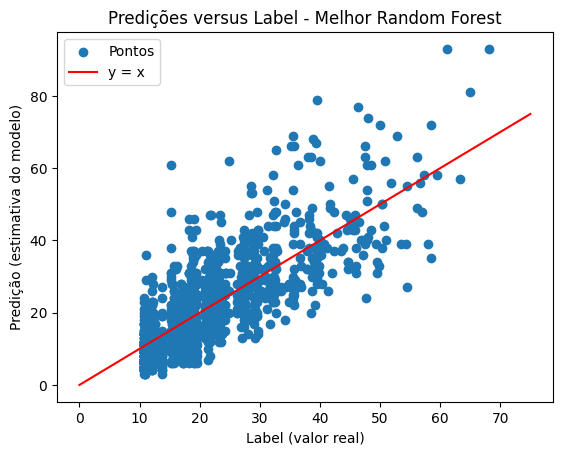

In [82]:
rf_researcher.get_model_train_scatterplot(9, n_estimators_list, max_depth_list, 
                                        title = 'Predições versus Label - Melhor Random Forest')

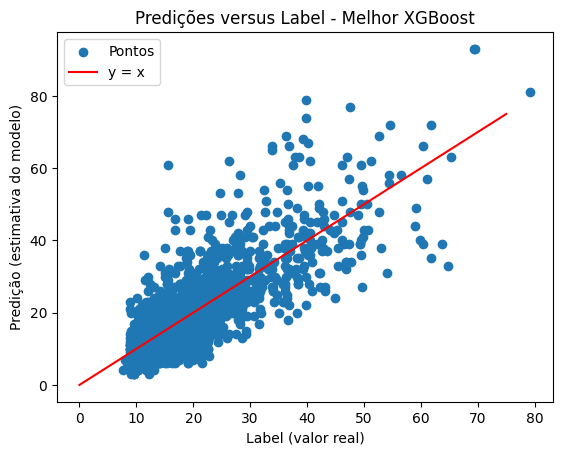

In [83]:
xgb_researcher.get_model_train_scatterplot(6, n_estimators_list, max_depth_list, learning_rate_list,
                                        title = 'Predições versus Label - Melhor XGBoost')

Aparentemente, o gráfico do XGBoost tem uma proximidade maior com os pontos da reta y = x, na média, do que o gráfico da Random Forest.

É claro que o modelo é longe de ser bom para ser usado na prática. O ideal seria testar outras features (se existirem) e obter mais dados para treiná-lo. Além disso, poderia-se testar outros modelos de aprendizado de máquina para tentar obter melhores resultados.

---

# Extra - Adicionando novas features: dia da semana e feature cross

## Dia da semana

Vamos verificar se adicionando a feature do dia da semana nós conseguimos um melhor resultado com o modelo de XGBoost.

In [84]:
from datetime import datetime

In [85]:
new_data = data.copy()

### Adicionando nova feature

In [86]:
new_data['Data'] = new_data['Data'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [87]:
new_data['Dia da Semana'] = new_data['Data'].apply(lambda x: x.weekday())

### Relação da nova feature com o target: visualização gráfica

Text(0.5, 0, 'Dia da Semana')

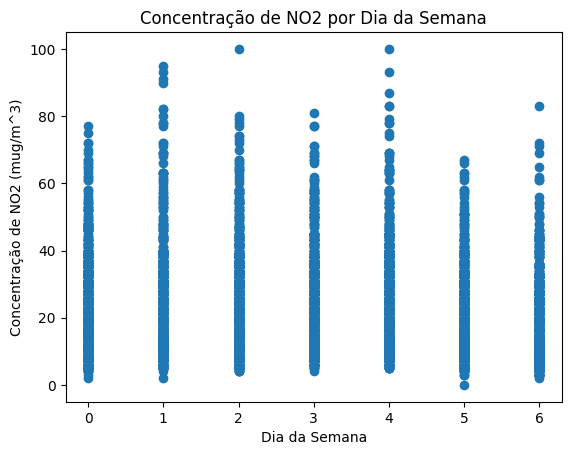

In [88]:
_ = plt.scatter(new_data['Dia da Semana'], new_data['Concentração_NO2'])
plt.title('Concentração de NO2 por Dia da Semana')
plt.ylabel('Concentração de NO2 (mug/m^3)')
plt.xlabel('Dia da Semana')

## Preparação dos dados

### Separando em features e label

- X: features
- y: label

In [89]:
new_features = features + ['Dia da Semana']
X = new_data[new_features]
y = new_data['Concentração_NO2']

### Treinando 10 modelos diferentes de XGBoost variando n_estimators

Obs: Manteremos max_depth = 5 e learning_rate = 0.1 para evitar overfitting.

In [90]:
test_size = 0.2
val_size = 0.2
random_state = 0

new_xgb_researcher = XGB_Researcher(X, y, test_size, val_size, random_state)

n_models = 10
n_estimators_list = [2**n for n in range(1, n_models + 1)]
max_depth_list = [5 for i in range(0, n_models)]
learning_rate_list = [0.1 for i in range(0, n_models)]
k = 5

new_xgb_report = new_xgb_researcher.get_n_models_research_report_df(n_models, n_estimators_list, max_depth_list, learning_rate_list, k)

new_xgb_report

,train error,val error,test error,kfold score error (k = 5)
model 1,387.130413,374.355054,384.043001,385.140843
model 2,275.465371,265.079831,273.813609,274.507766
model 3,152.189230,145.336997,152.180075,153.244062
model 4,73.699330,72.010249,74.715015,76.608550
model 5,53.464807,56.093514,55.828458,58.629838
model 6,50.623478,56.453756,55.178651,58.143596
model 7,47.495478,57.451618,56.058296,59.007343
model 8,43.584706,60.017615,57.933490,60.882006
model 9,39.632596,63.729409,60.308427,64.316022
model 10,35.442707,68.277778,64.648904,68.808237


Conseguimos um modelo melhor com a nova feature! O modelo escolhido é o modelo 6.

In [91]:
new_best_xgb_index = 'model 6'
new_best_xgb_df = pd.DataFrame(new_xgb_report.loc[new_best_xgb_index])
new_best_xgb_df = new_best_xgb_df.rename(columns = {new_best_xgb_index: 'New Best XGBoost Model'})

Comparando o modelo antigo e o novo:

In [92]:
comparison_xgb_df = pd.concat([best_xgb_df, new_best_xgb_df], axis = 1)

In [93]:
comparison_xgb_df

,Best XGBoost Model,New Best XGBoost Model
train error,53.338564,50.623478
val error,58.772497,56.453756
test error,57.507082,55.178651
kfold score error (k = 5),59.967779,58.143596


De fato, todos os erros são menores com o novo modelo, de forma que a adição da nova feature (dias da semana) ajudou o modelo a aprender!

## Dia da semana ao quadrado: feature cross

Sabemos de antemão que provavelmente elevar o dia da semana ao quadrado não deve auxiliar o modelo, dado que a relação entre o target e o dia da semana não parece ser descrita por uma transformação como essa.

Mas, como teste:

Agora vamos adicionar a feature do dia da semana ao quadrado (feature cross dessa feature com ela mesma). Por quê? Para causar maior diferenciação entre o fim de semana e os dias da semana! Outra forma de fazer isso sem utilizar feature cross seria adicionar uma feature booleana.

In [94]:
newest_data = new_data.copy()

### Adicionando nova feature

In [95]:
newest_data['Dia da Semana ao Quadrado'] = newest_data['Dia da Semana']**2

In [96]:
newest_data.head()

,Data,Hora,Concentração_NO,Concentração_NO2,Unidade,Dia da Semana,Dia da Semana ao Quadrado
0,2017-01-01,2.0,2.0,18.0,ug/m3,6,36
1,2017-01-01,3.0,2.0,15.0,ug/m3,6,36
2,2017-01-01,4.0,1.0,7.0,ug/m3,6,36
3,2017-01-01,5.0,1.0,6.0,ug/m3,6,36
4,2017-01-01,6.0,0.0,6.0,ug/m3,6,36


In [97]:
newest_features = new_features + ['Dia da Semana ao Quadrado']
X = newest_data[newest_features]
y = newest_data['Concentração_NO2']

In [98]:
test_size = 0.2
val_size = 0.2
random_state = 0

newest_xgb_researcher = XGB_Researcher(X, y, test_size, val_size, random_state)

n_models = 10
n_estimators_list = [2**n for n in range(1, n_models + 1)]
max_depth_list = [5 for i in range(0, n_models)]
learning_rate_list = [0.1 for i in range(0, n_models)]
k = 5

newest_xgb_report = newest_xgb_researcher.get_n_models_research_report_df(n_models, n_estimators_list, max_depth_list, learning_rate_list, k)

newest_xgb_report

,train error,val error,test error,kfold score error (k = 5)
model 1,387.130413,374.355054,384.043001,385.140843
model 2,275.465371,265.079831,273.813609,274.507766
model 3,152.189230,145.336997,152.180075,153.244062
model 4,73.699330,72.010249,74.715015,76.608550
model 5,53.464807,56.093514,55.828458,58.629838
model 6,50.623478,56.453756,55.178651,58.143596
model 7,47.495478,57.451618,56.058296,59.007343
model 8,43.584706,60.017615,57.933490,60.882006
model 9,39.632596,63.729409,60.308427,64.316022
model 10,35.442707,68.277778,64.648904,68.808237


Não conseguimos uma melhoria no score do Kfold! Na verdade, conseguimos os mesmos resultados.

Assim, na prática, a adição dessa nova feature não muda em nada o modelo! Iremos comparar esse resultado aos anteriores. Uma hipótese para isso acontecer é que a quadratura do dia da semana não realça nenhuma relação com o target. Isto é, elevar ou não dia da semana ao quadrado não altera em nada o resultado final, já que as não-linearidades já são representadas pela complexidade do modelo.

In [99]:
newest_best_xgb_index = 'model 6'
newest_best_xgb_df = pd.DataFrame(newest_xgb_report.loc[newest_best_xgb_index])
newest_best_xgb_df = newest_best_xgb_df.rename(columns = {newest_best_xgb_index: 'Newest Best XGBoost Model'})

Finalmente, comparando todos os modelos:

In [100]:
newest_comparison_xgb_df = pd.concat([comparison_xgb_df, newest_best_xgb_df], axis = 1)

In [101]:
newest_comparison_xgb_df

,Best XGBoost Model,New Best XGBoost Model,Newest Best XGBoost Model
train error,53.338564,50.623478,50.623478
val error,58.772497,56.453756,56.453756
test error,57.507082,55.178651,55.178651
kfold score error (k = 5),59.967779,58.143596,58.143596


Se fossemos ficar com um modelo, ficariamos com o **New Best XGBoost Model**, ou seja, o modelo após a adição da feature de dias da semana mas antes da adição da diferenciação maior entre dia da semana e fim de semana (quadratura da feature 'Dia da Semana').

# Visualização Gráfica do Melhor Modelo

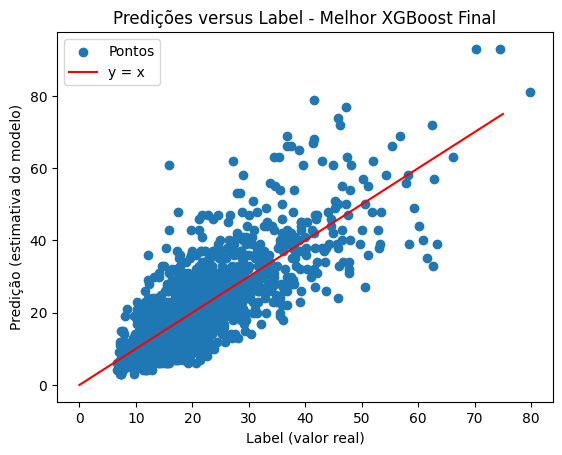

In [102]:
new_xgb_researcher.get_model_train_scatterplot(6, n_estimators_list, max_depth_list, learning_rate_list,
                                        title = 'Predições versus Label - Melhor XGBoost Final')

# Conclusão

Assim, finalizamos a parte extra de adição de novas features com **melhorias** no score error na validação cruzada (Kfold) após a adição da **primeira feature nova** e **não muda** após a adição da **segunda**!

Esse resultado mostra que a adição de novas features nem sempre causa melhorias na predição do modelo. Assim, devemos ter cuidado e analisar as relações entre a feature e o target uma a uma antes de adicioná-las ao modelo.

---